<a href="https://colab.research.google.com/github/thntran/learn/blob/master/GNN_PyTorchGeometric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Geometric installation
It requires Pytorch Geometric to creat graph neural networks. Pytorch is already install on Colab so we just need to install some additional packages.

**See if PyTorch and system CUDA versions match**

In [1]:
!python -c "import torch; print(torch.version.cuda)"

10.1


In [2]:
!python -c "import torch; print(torch.__version__)"

1.6.0+cu101


**Install needed packages**

In [3]:
!pip install torch-scatter==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.6.0.html
!pip install torch-cluster==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.6.0.html
!pip install torch-sparse==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.6.0.html
!pip install torch-spline-conv==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.6.0.html
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-1.6.0.html
     |████████████████████████████████| 11.5MB 5.9MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.6.0.html
     |████████████████████████████████| 20.3MB 1.3MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.6.0.html
     |████████████████████████████████| 22.9MB 187kB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.6.0.html
     |████████████████████████████████| 6.1MB 46kB/s 
     |████████████████████████████████| 184kB 3.4MB/s 
     |████████████████████████████████| 235kB 8.9MB/s 
     |████████████████████████████████| 2.2MB 11.7MB/s 
     |████████████████████████████████| 51kB 4.6MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-1.6.1-cp36-none-any.whl size=308551 sha256=44e01a24f648ae33186a8b96f28cdd810a5116a83980bc89f8bd0e996c6513dd
  Stored in directory: /root/.cache/pip/wheels/e6/25/ea/3d71d2088dccc63214fa59259dcc598ded4150a5f8b41d84ff
Succe

#Graph Convolutional networks

**Import libraries**

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

import networkx as nx
import numpy as np
import torch
import torch.optim as optim

from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader

import torch_geometric.transforms as T

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

**Define the model**

In [5]:
class GNNStack(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, task='node'):
        super(GNNStack, self).__init__()
        self.task = task
        self.convs = nn.ModuleList()
        self.convs.append(self.build_conv_model(input_dim, hidden_dim))
        self.lns = nn.ModuleList()
        self.lns.append(nn.LayerNorm(hidden_dim))
        self.lns.append(nn.LayerNorm(hidden_dim))
        for l in range(2):
            self.convs.append(self.build_conv_model(hidden_dim, hidden_dim))

        # post-message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.Dropout(0.25), 
            nn.Linear(hidden_dim, output_dim))
        if not (self.task == 'node' or self.task == 'graph'):
            raise RuntimeError('Unknown task.')

        self.dropout = 0.25
        self.num_layers = 3

    def build_conv_model(self, input_dim, hidden_dim):
        # refer to pytorch geometric nn module for different implementation of GNNs.
        if self.task == 'node':
            return pyg_nn.GCNConv(input_dim, hidden_dim) # graph convolutional network for node classification
        else:
            return pyg_nn.GINConv(nn.Sequential(nn.Linear(input_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, hidden_dim))) # graph isomorphism network for graph classification

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        if data.num_node_features == 0:
          x = torch.ones(data.num_nodes, 1)

        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            emb = x
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            if not i == self.num_layers - 1:
                x = self.lns[i](x)

        if self.task == 'graph':
            x = pyg_nn.global_mean_pool(x, batch)

        x = self.post_mp(x)

        return emb, F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

In [6]:
class CustomConv(pyg_nn.MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(CustomConv, self).__init__(aggr='add')  # "Add" aggregation.
        self.lin = nn.Linear(in_channels, out_channels)
        self.lin_self = nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Add self-loops to the adjacency matrix.
        edge_index, _ = pyg_utils.remove_self_loops(edge_index)

        # Transform node feature matrix.
        self_x = self.lin_self(x)
        #x = self.lin(x)

        return self_x + self.propagate(edge_index, size=(x.size(0), x.size(0)), x=self.lin(x))

    def message(self, x_i, x_j, edge_index, size):
        # Compute messages
        # x_j has shape [E, out_channels]
        row, col = edge_index
        deg = pyg_utils.degree(row, size[0], dtype=x_j.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        return x_j

    def update(self, aggr_out):
        # aggr_out has shape [N, out_channels]
        return aggr_out

**Training setup**
- for node classification task, define a subset of nodes to be training nodes and the rest of the nodes to be test nodes, and mask out the test nodes during training via batch.train_mask
- for graph classification, use 80% of the graphs for training and the remainder for testing

In [11]:
!pip install tensorboardX

     |████████████████████████████████| 317kB 3.5MB/s 


In [12]:
from tensorboardX import SummaryWriter

In [7]:
def train(dataset, task, writer):
    if task == 'graph':
        data_size = len(dataset)
        loader = DataLoader(dataset[:int(data_size * 0.8)], batch_size=64, shuffle=True)
        test_loader = DataLoader(dataset[int(data_size * 0.8):], batch_size=64, shuffle=True)
    else:
        test_loader = loader = DataLoader(dataset, batch_size=64, shuffle=True)

    # build model
    model = GNNStack(max(dataset.num_node_features, 1), 32, dataset.num_classes, task=task)
    opt = optim.Adam(model.parameters(), lr=0.01)
    
    # train
    for epoch in range(200):
        total_loss = 0
        model.train()
        for batch in loader:
            #print(batch.train_mask, '----')
            opt.zero_grad()
            embedding, pred = model(batch)
            label = batch.y
            if task == 'node':
                pred = pred[batch.train_mask]
                label = label[batch.train_mask]
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs
        total_loss /= len(loader.dataset)
        writer.add_scalar("loss", total_loss, epoch)

        if epoch % 10 == 0:
            test_acc = test(test_loader, model)
            print("Epoch {}. Loss: {:.4f}. Test accuracy: {:.4f}".format(
                epoch, total_loss, test_acc))
            writer.add_scalar("test accuracy", test_acc, epoch)

    return model

In [8]:
def test(loader, model, is_validation=False):
    model.eval()

    correct = 0
    for data in loader:
        with torch.no_grad():
            emb, pred = model(data)
            pred = pred.argmax(dim=1)
            label = data.y

        if model.task == 'node':
            mask = data.val_mask if is_validation else data.test_mask
            # node classification: only evaluate on nodes in test set
            pred = pred[mask]
            label = data.y[mask]
            
        correct += pred.eq(label).sum().item()
    
    if model.task == 'graph':
        total = len(loader.dataset) 
    else:
        total = 0
        for data in loader.dataset:
            total += torch.sum(data.test_mask).item()
    return correct / total

**Train the model**

Graph classification task on dataset ENZYMES:



In [13]:
writer = SummaryWriter("./log/")
dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES')
dataset = dataset.shuffle()
task = 'graph'
model = train(dataset, task, writer)

Epoch 0. Loss: 1.8308. Test accuracy: 0.1333
Epoch 10. Loss: 1.7915. Test accuracy: 0.1917
Epoch 20. Loss: 1.7590. Test accuracy: 0.2000
Epoch 30. Loss: 1.7488. Test accuracy: 0.2167
Epoch 40. Loss: 1.7388. Test accuracy: 0.2167
Epoch 50. Loss: 1.7428. Test accuracy: 0.1667
Epoch 60. Loss: 1.7073. Test accuracy: 0.2333
Epoch 70. Loss: 1.7023. Test accuracy: 0.2333
Epoch 80. Loss: 1.6963. Test accuracy: 0.2083
Epoch 90. Loss: 1.6939. Test accuracy: 0.2083
Epoch 100. Loss: 1.6869. Test accuracy: 0.2333
Epoch 110. Loss: 1.6778. Test accuracy: 0.2167
Epoch 120. Loss: 1.6677. Test accuracy: 0.2333
Epoch 130. Loss: 1.6813. Test accuracy: 0.2333
Epoch 140. Loss: 1.6693. Test accuracy: 0.2333
Epoch 150. Loss: 1.6826. Test accuracy: 0.2167
Epoch 160. Loss: 1.6679. Test accuracy: 0.2167
Epoch 170. Loss: 1.7029. Test accuracy: 0.2417
Epoch 180. Loss: 1.6668. Test accuracy: 0.2333
Epoch 190. Loss: 1.6840. Test accuracy: 0.2167


 Node classification task on dataset Cora:

In [14]:
writer = SummaryWriter("./log/")
dataset = Planetoid(root='/tmp/cora', name='cora')
task = 'node'
model = train(dataset, task, writer)

Processing...
Done!
Epoch 0. Loss: 1.9534. Test accuracy: 0.4070
Epoch 10. Loss: 0.3727. Test accuracy: 0.7760
Epoch 20. Loss: 0.1491. Test accuracy: 0.7370
Epoch 30. Loss: 0.0177. Test accuracy: 0.7270
Epoch 40. Loss: 0.0105. Test accuracy: 0.7410
Epoch 50. Loss: 0.0092. Test accuracy: 0.7350
Epoch 60. Loss: 0.0287. Test accuracy: 0.7440
Epoch 70. Loss: 0.1602. Test accuracy: 0.7340
Epoch 80. Loss: 0.0209. Test accuracy: 0.7220
Epoch 90. Loss: 0.0027. Test accuracy: 0.7410
Epoch 100. Loss: 0.0548. Test accuracy: 0.7290
Epoch 110. Loss: 0.0052. Test accuracy: 0.7340
Epoch 120. Loss: 0.0033. Test accuracy: 0.7370
Epoch 130. Loss: 0.0089. Test accuracy: 0.7400
Epoch 140. Loss: 0.0065. Test accuracy: 0.7240
Epoch 150. Loss: 0.0027. Test accuracy: 0.7490
Epoch 160. Loss: 0.0007. Test accuracy: 0.7350
Epoch 170. Loss: 0.0002. Test accuracy: 0.7400
Epoch 180. Loss: 0.0015. Test accuracy: 0.7350
Epoch 190. Loss: 0.0002. Test accuracy: 0.7360


**Visualize node embeddings**

for the output of the last convolutional layer in the node classification GNN via TSNE

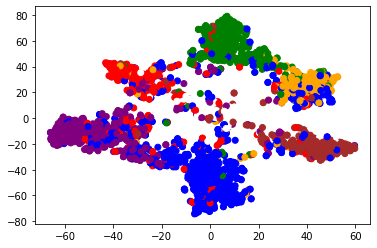

In [15]:
color_list = ["red", "orange", "green", "blue", "purple", "brown", "white"]

loader = DataLoader(dataset, batch_size=64, shuffle=True)
embs = []
colors = []
for batch in loader:
    emb, pred = model(batch)
    embs.append(emb)
    colors += [color_list[y] for y in batch.y]
embs = torch.cat(embs, dim=0)

xs, ys = zip(*TSNE().fit_transform(embs.detach().numpy()))
plt.scatter(xs, ys, color=colors)

# Graph autoencoder

**Learn unsupervised embeddings on the dataset Citeseer**

In [16]:
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, GAE
from torch_geometric.utils import train_test_split_edges

In [19]:
class Encoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Encoder, self).__init__()
        self.conv1 = pyg_nn.GCNConv(in_channels, 2 * out_channels, cached=True)
        self.conv2 = pyg_nn.GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2(x, edge_index)

def train(epoch):
    model.train()
    optimizer.zero_grad()
    z = model.encode(x, train_pos_edge_index)
    loss = model.recon_loss(z, train_pos_edge_index)
    loss.backward()
    optimizer.step()
    
    writer.add_scalar("loss", loss.item(), epoch)

def test(pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, train_pos_edge_index)
    return model.test(z, pos_edge_index, neg_edge_index)

writer = SummaryWriter("./log/")

dataset = Planetoid("/tmp/citeseer", "Citeseer", transform=T.NormalizeFeatures())
data = dataset[0]

channels = 16
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('CUDA availability:', torch.cuda.is_available())

# encoder: written by us; decoder: default (inner product)
model = pyg_nn.GAE(Encoder(dataset.num_features, channels)).to(dev)
labels = data.y
data.train_mask = data.val_mask = data.test_mask = data.y = None
data = train_test_split_edges(data)
x, train_pos_edge_index = data.x.to(dev), data.train_pos_edge_index.to(dev)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(1, 201):
    train(epoch)
    auc, ap = test(data.test_pos_edge_index, data.test_neg_edge_index)
    writer.add_scalar("AUC", auc, epoch)
    writer.add_scalar("AP", ap, epoch)
    if epoch % 10 == 0:
        print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))

CUDA availability: False
Epoch: 010, AUC: 0.6916, AP: 0.7482
Epoch: 020, AUC: 0.8173, AP: 0.8200
Epoch: 030, AUC: 0.8284, AP: 0.8253
Epoch: 040, AUC: 0.8511, AP: 0.8422
Epoch: 050, AUC: 0.8987, AP: 0.8929
Epoch: 060, AUC: 0.9067, AP: 0.9007
Epoch: 070, AUC: 0.9056, AP: 0.9035
Epoch: 080, AUC: 0.9062, AP: 0.9022
Epoch: 090, AUC: 0.9097, AP: 0.9074
Epoch: 100, AUC: 0.9119, AP: 0.9136
Epoch: 110, AUC: 0.9086, AP: 0.9113
Epoch: 120, AUC: 0.9069, AP: 0.9091
Epoch: 130, AUC: 0.9034, AP: 0.9077
Epoch: 140, AUC: 0.8986, AP: 0.9032
Epoch: 150, AUC: 0.8963, AP: 0.9012
Epoch: 160, AUC: 0.8948, AP: 0.9005
Epoch: 170, AUC: 0.8925, AP: 0.8981
Epoch: 180, AUC: 0.8919, AP: 0.8978
Epoch: 190, AUC: 0.8921, AP: 0.8979
Epoch: 200, AUC: 0.8917, AP: 0.8980


**Visualize the embeddings with TSNE**

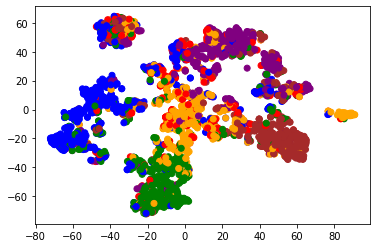

In [20]:
model.eval()
z = model.encode(x, train_pos_edge_index)
colors = [color_list[y] for y in labels]

xs, ys = zip(*TSNE().fit_transform(z.cpu().detach().numpy()))
plt.scatter(xs, ys, color=colors)
plt.show()